In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import json
from scipy import stats

### Домашнее задание 2. Интерпретация результатов АБ-теста

Срок сдачи: 31 марта 18:00

На мобильной версии Авито провели тест на добавление рекламного баннера на карточку товара между описанием и блоком рекомендаций.

Продуктовая гипотеза:
Добавление рекламного баннера будет приводить к увелечинию выручки без ущерба пользовательскому опыт.

<div>
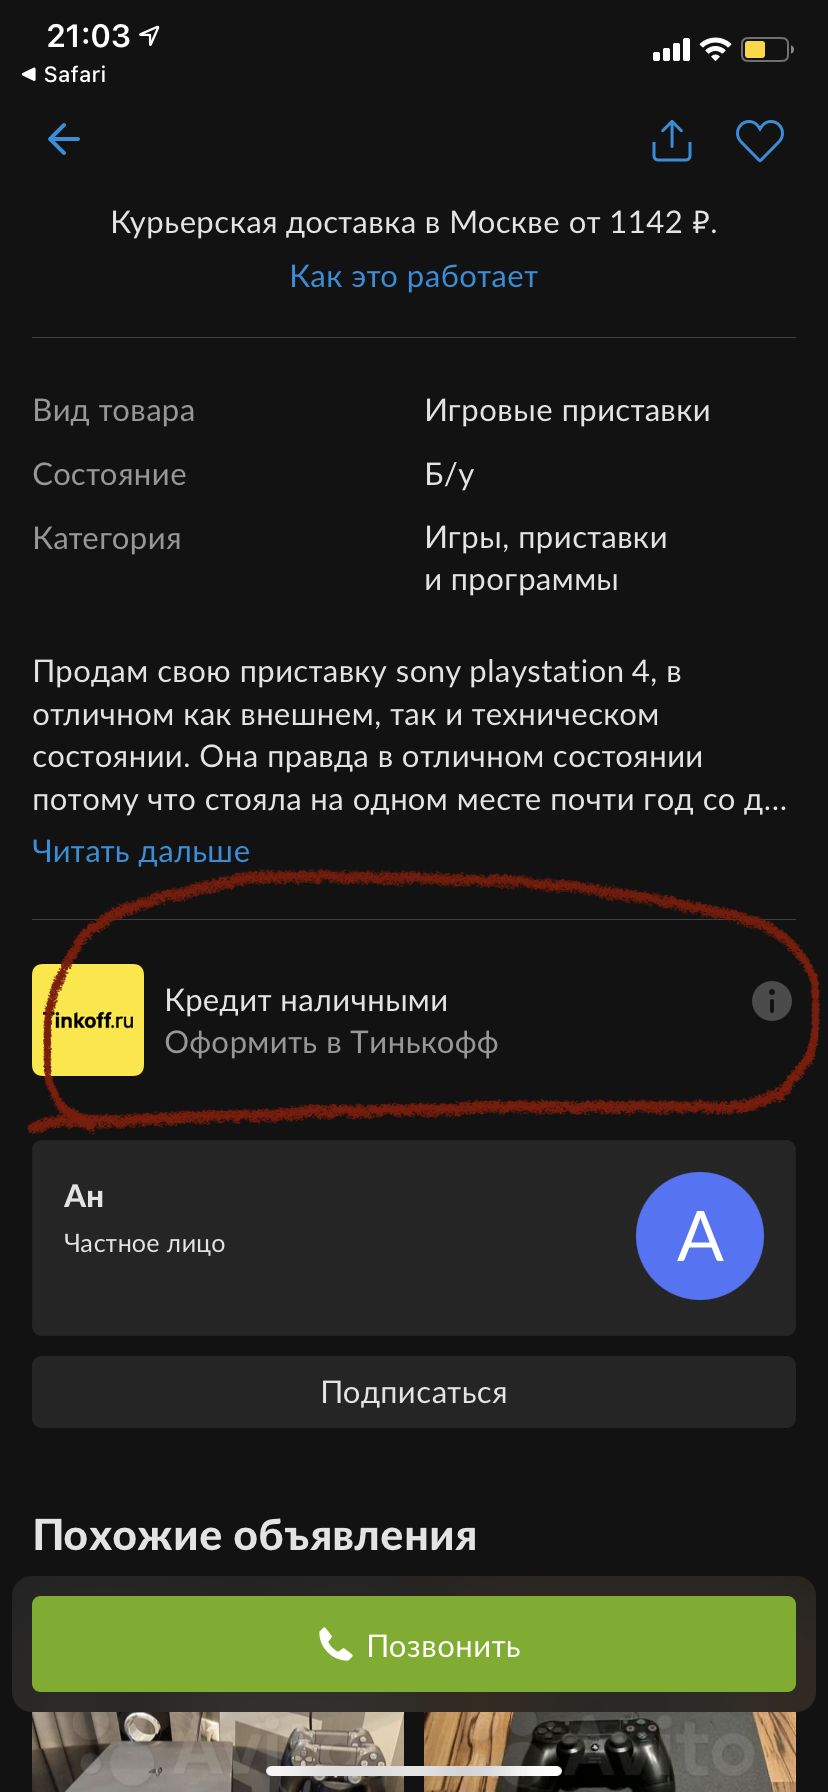
</div>

Задание:
1. Загрузите файл с данными, собранными за время аб теста.

2. На основе имеющихя в файле метрик формализуйте продуктовую гипотезу. Помимо количественных метрик рекомендую использовать ratio-метрики и метрики аггрегированные по пользователям(например, количество пользователей совершивших контакт) и при анализе теста обратите внимание на их чувтсвительность. (2 балла)

3.  Используя критерий Стьюдента, проинтерпретируйте как изменились средние выборок для выбранных вами метрик. Используйте уровень значимости 0.01.(2 балла)

4.  Выборка разделена на 200 бакетов. Примените к бакетам критерий Стьюдента и проинтерпретируйте как изменились средние выборок для выбранных вами метрик. Используйте уровень значимости 0.01. Сравните результаты с предыдущим пунктом. (2 балла)

6. Для анализа сформулированных в п.2 ratio-метрик воспольуйтесь Бутстрэпом. Являются ли эти метрики более чувствительными, чем базовые метрики? (2 балла)

7. Проинтерпретируйте результаты и сделайте выводы об изменениях для продукта. Рекомендуете ли вы изменение к запуску на 100% пользователей? (2 балла)

Формат данных

cookie_id - ид пользователя

split_group	- тестовая группа

searches - количество поисков

item_views - количество просмотров объявлений

contacts - количество контактов пользователя с продавцом	

rec_item_views - количество просмотров объявлений с рекомендацией

rec_contacts - контакты с рекомендацией

contact_cookie - пользователь, совершил контакт

advertising_clicks - клики на всю рекламу(Помимо добавленного баннера есть ещё баннеры в других местах. Эта метрика их учитывает.)

bucket - бакет

In [7]:
df = pd.read_csv('banner_test_results.csv')

In [8]:
df.shape

(1010805, 10)

Посмотрим данные, что они из себя представляют

In [9]:
df.head()

,cookie_id,split_group,searches,item_views,contacts,rec_item_views,rec_contacts,contact_cookie,advertising_clicks,bucket
0,5898517031,test,0,21,7,0,0,1,0,31
1,28204005253,test,0,16,0,1,0,0,0,53
2,37285261090,test,0,4,0,0,0,0,0,90
3,48663044440,test,0,3,0,0,0,0,0,40
4,48835061540,test,0,2,0,0,0,0,0,140


In [10]:
df.describe()

,cookie_id,searches,item_views,contacts,rec_item_views,rec_contacts,contact_cookie,advertising_clicks,bucket
count,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06,1.010805e+06
mean,3.374705e+12,9.455460e+01,6.826200e+02,1.172740e+01,2.815135e+01,2.680369e-01,1.514733e-01,3.637388e-01,9.944952e+01
std,8.433758e+11,1.994381e+03,4.140407e+03,3.416695e+02,1.903826e+02,3.859788e+00,3.585098e-01,5.649970e+00,5.775915e+01
min,5.898517e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.322187e+12,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01
50%,3.730785e+12,0.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.900000e+01
75%,3.905482e+12,2.000000e+00,1.440000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+02
max,3.967647e+12,1.431396e+06,4.679680e+05,1.336170e+05,5.000000e+03,1.760000e+02,1.000000e+00,6.610000e+02,1.990000e+02


In [6]:
df[df['cookie_id'].duplicated()].shape

(0, 10)

Нет дублей по пользователям. То есть агрегировать по юзеру не надо.

Основная продуктовая гипотеза заключается в том, что мы имеем увеличение наших продуктовых метрик. В качестве метрик предлагается взять:
1. advertising_clicks - используется в качестве прокси, что будет свидетельствовать о том, увеличилась ли наша выручка или нет при условии не изменения пользовательского опыта.
2. Также будем отслеживать количество contacts в качестве сигнала изменения изменения пользовательского опыта в целом, а также так как было изменение положения рекомендаций, то требуется также смотреть и rec_contacts.
3. В качестве ratio-метрики возьмем конверсию перехода к контакту через клик, т.е. contacts / advertising_clicks 
4. Так же в качестве еще одной ratio-метрики возьмем отношение количество просмотров рекомендаций в разных группах. Ожидаем увидеть в доверительном интервале 1, так как это будет свидетельствовать о том, что опыт не изменился.

In [17]:
df['convertion2contact'] = df['contacts'] / df['advertising_clicks']

In [8]:
# Посмотрим количество пропусков
df['convertion2contact'].isna().mean()

0.8395664841388794

In [9]:
# Заполним пропуски и так же бесконечности, которые появляются, когда делим на 0, очевидно, что лучшая замена на 0.0
df['convertion2contact'].replace([-np.nan, np.nan, np.inf], 0, inplace=True)
df['convertion2contact'].fillna(0, inplace=True)

In [10]:
df['convertion2contact'].describe()

count    1.010805e+06
mean     8.325577e-02
std      6.686789e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.927833e+03
Name: convertion2contact, dtype: float64

In [11]:
df['advertising_clicks'].describe()

count    1.010805e+06
mean     3.637388e-01
std      5.649970e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.610000e+02
Name: advertising_clicks, dtype: float64

Ожидаем, что чувствительность для не ratio метрик будет крайне не высокой, кроме, возможно, advertising_clicks, так как значения достаточно маленькие, включая низкую дисперсию.

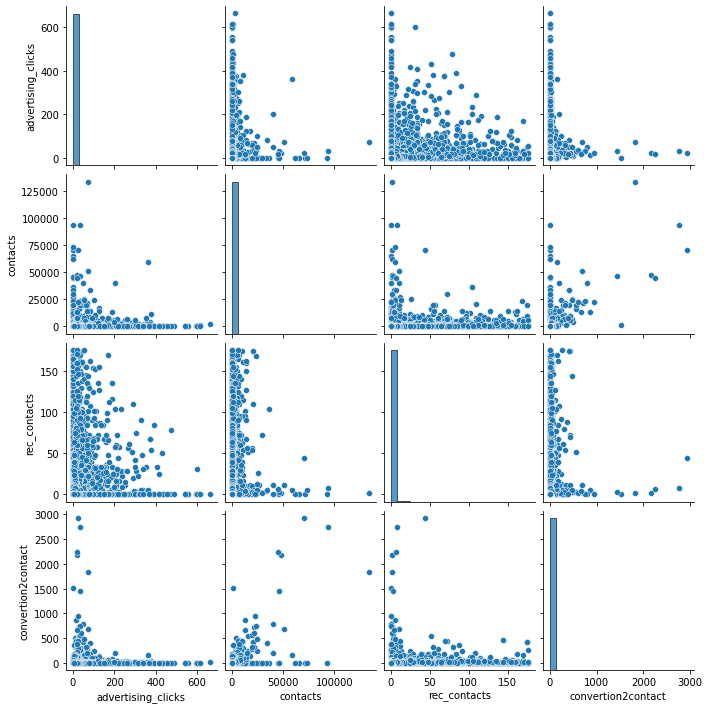

In [31]:
sns.pairplot(df[['advertising_clicks', 'contacts', 'rec_contacts',
                'convertion2contact']])

## Применяем Стьюдента - проверка гипотез о равенстве средних в тесте и контроле

In [11]:
CONST_ALPHA = 0.01

In [12]:
# посмотрим, сколько у нас вообще в тесте и контроле - на всякий случай.
df['split_group'].value_counts()

test       507422
control    503383
Name: split_group, dtype: int64

In [20]:
# разделим выборку на test, control для удобства
df_test = df[df['split_group'] == 'test']
df_control = df[df['split_group'] == 'control']

In [87]:
df_test.columns

Index(['cookie_id', 'split_group', 'searches', 'item_views', 'contacts',
       'rec_item_views', 'rec_contacts', 'contact_cookie',
       'advertising_clicks', 'bucket', 'convertion2contact'],
      dtype='object')

In [88]:
stats.ttest_ind(df_test['advertising_clicks'], df_control['advertising_clicks'], equal_var=False)

Ttest_indResult(statistic=2.7774193092517643, pvalue=0.005479345352518287)

In [89]:
stats.ttest_ind(df_test['advertising_clicks'], df_control['advertising_clicks'], equal_var=False)[1] < CONST_ALPHA

True

In [90]:
df_test['advertising_clicks'].mean() - df_control['advertising_clicks'].mean()

0.031210986959803955

Отвергаем гипотезу о равенстве средних, поэтому есть статистическая разница между средними в тесте и контроле => есть значимое изменение. Это сходится с нашими ожиданиями, то есть мы имеем увеличение нашей прокси метрики и наш тест это обнаружил.

In [91]:
stats.ttest_ind(df_test['contacts'], df_control['contacts'], equal_var=False)

Ttest_indResult(statistic=2.0728019166949747, pvalue=0.03819098183197387)

In [92]:
stats.ttest_ind(df_test['contacts'], df_control['contacts'], equal_var=False)[1] <= CONST_ALPHA

False

In [93]:
stats.ttest_ind(df_test['rec_contacts'], df_control['rec_contacts'], equal_var=False)

Ttest_indResult(statistic=-2.857177622903359, pvalue=0.004274353247777261)

In [94]:
stats.ttest_ind(df_test['rec_contacts'], df_control['rec_contacts'], equal_var=False)[1] <= CONST_ALPHA

True

In [171]:
(df_test['rec_contacts'].mean() - df_control['rec_contacts'].mean()) / df_control['rec_contacts'].mean()

-0.07863220002490912

Для contacts наш тест не обнаружил стат значимое отклонение, когда для rec_contacts он обнаружил, более того, видим, что оно уменьшилось, значит пользовательский опыт упал.

Проверим так же и на ratio метриках, однако заранее понятно, что мы обречены на провал

In [147]:
ratio_use = df_test.reset_index()['rec_item_views'][:503_000] / df_control.reset_index()['rec_item_views'][:503_000]

In [149]:
ratio_use.replace(np.inf, 0.0, inplace=True)
ratio_use.fillna(0.0, inplace=True)

In [150]:
stats.ttest_1samp(ratio_use, 1.0)

Ttest_1sampResult(statistic=2.4886687259931506, pvalue=0.012822558781612505)

In [151]:
stats.ttest_1samp(ratio_use, 1.0)[1] <= CONST_ALPHA

False

In [160]:
stats.ttest_ind(df_test['convertion2contact'], df_control['convertion2contact'], equal_var=False)

Ttest_indResult(statistic=0.37609010529524534, pvalue=0.7068499901608356)

In [161]:
stats.ttest_ind(df_test['convertion2contact'], df_control['convertion2contact'], equal_var=False)[1] <= CONST_ALPHA

False

Получили ожидаемые результаты - ничего не прокрасилось.

## Попробуем бакетирование наших метрик

In [21]:
test_by_bucket = df_test.groupby('bucket').sum()[['rec_contacts', 'contacts', 'advertising_clicks',
                                                  'rec_item_views', 'convertion2contact']].reset_index()
control_by_bucket = df_control.groupby('bucket').sum()[['rec_contacts', 'contacts', 'advertising_clicks',
                                                       'rec_item_views', 'convertion2contact']].reset_index()

In [97]:
stats.ttest_ind(test_by_bucket['advertising_clicks'], control_by_bucket['advertising_clicks'])

Ttest_indResult(statistic=2.903474497354157, pvalue=0.0038959846947274677)

In [98]:
stats.ttest_ind(test_by_bucket['advertising_clicks'], control_by_bucket['advertising_clicks'])[1] <= CONST_ALPHA

True

In [99]:
stats.ttest_ind(test_by_bucket['contacts'], control_by_bucket['contacts'])

Ttest_indResult(statistic=2.2757200773162736, pvalue=0.023393534635430747)

In [100]:
stats.ttest_ind(test_by_bucket['contacts'], control_by_bucket['contacts'])[1] <= CONST_ALPHA

False

In [106]:
stats.ttest_ind(test_by_bucket['rec_contacts'], control_by_bucket['rec_contacts'])

Ttest_indResult(statistic=-2.5120937082199717, pvalue=0.012396516305234341)

In [107]:
stats.ttest_ind(test_by_bucket['rec_contacts'], control_by_bucket['rec_contacts'])[1] <= CONST_ALPHA

False

По бакетам мы видим стат значимость в различии средних advertising_clicks, а вот для rec_contacts мы это уже не увидели, то есть, кажется, что пользовательский опыт не поменялся - чувствительность тестов уменьшилась.

И попробуем опять для ratio

In [162]:
ratio_use_bucker = (test_by_bucket.reset_index()['rec_item_views'][:503_000] /
                    control_by_bucket.reset_index()['rec_item_views'][:503_000])

In [163]:
stats.ttest_1samp(ratio_use_bucker, 1.0)

Ttest_1sampResult(statistic=-1.6858450290494624, pvalue=0.0933929114239007)

In [164]:
stats.ttest_1samp(ratio_use_bucker, 1.0)[1] <= CONST_ALPHA

False

In [166]:
test_by_bucket.columns

Index(['bucket', 'rec_contacts', 'contacts', 'advertising_clicks',
       'rec_item_views'],
      dtype='object')

In [169]:
stats.ttest_ind(test_by_bucket['convertion2contact'],
                control_by_bucket['convertion2contact'], equal_var=False)

Ttest_indResult(statistic=0.43893345136143336, pvalue=0.6609494567916139)

In [170]:
stats.ttest_ind(test_by_bucket['convertion2contact'],
                control_by_bucket['convertion2contact'], equal_var=False)[1] <= CONST_ALPHA

False

Очевидно, что тут ничего не прокрашивается, что в целом понятно.

## Посмотрим на ratio-метрики с помощью бутстрепа

In [13]:
def stat_intervals(stat, alpha = 0.05):
    return np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

def get_bootstrap_samples(sample1, sample2, 
                              n_samples, 
                              custom_func = np.mean, ):
    return np.array([custom_func(sample1, sample2, np.random.randint(0, len(sample1), len(sample1)))
                     for _ in range(n_samples)])

In [14]:
def get_ratio_metric(x,y,item):
    return x[item].sum() / y[item].sum()

In [137]:
rec_item = get_bootstrap_samples(test_by_bucket['rec_item_views'], control_by_bucket['rec_item_views']
                                ,5000,get_ratio_metric)

In [138]:
stat_intervals(rec_item, 0.01)

array([0.92559942, 0.99142156])

Не видим единицу в доверительном интервале, поэтому делаем вывод, что количество объявлений с рекомендацией в тесте просело => пользовательский опыт ухудшился.

In [22]:
conversion_test_bucket =  get_bootstrap_samples(test_by_bucket['contacts'], test_by_bucket['advertising_clicks'],
                                           5000, get_ratio_metric)
conversion_control_bucket = get_bootstrap_samples(control_by_bucket['contacts'], control_by_bucket['advertising_clicks'],
                                           5000, get_ratio_metric)

In [23]:
stat_intervals(conversion_test_bucket / conversion_control_bucket, 0.01)

array([0.88272219, 1.21721115])

Попробуем без бакетов

In [139]:
len(df_test), len(df_control)

(507422, 503383)

In [141]:
df_test_use = df_test.reset_index()
df_control_user = df_control.reset_index()

In [142]:
rec_item_no_bucket = get_bootstrap_samples(df_test_use['rec_item_views'][:503000],
                                           df_control_user['rec_item_views'][:503000],
                                           5000, get_ratio_metric)

In [143]:
stat_intervals(rec_item_no_bucket, 0.01)

array([0.88529366, 0.94752251])

Предсказуемый результат! Опять же видим, что единицы нет в нашем интервале => отвергаем гипотезу о равенстве в тесте и контроле => мы имеем уменьшение объявлений с рекомендаций, то есть ухудшение пользовательского опыта.

In [158]:
conversion_test =  get_bootstrap_samples(df_test_use['contacts'], df_test_use['advertising_clicks'],
                                           5000, get_ratio_metric)
conversion_control = get_bootstrap_samples(df_control_user['contacts'], df_control_user['advertising_clicks'],
                                           5000, get_ratio_metric)

In [159]:
stat_intervals(conversion_test / conversion_control, 0.01)

array([0.88779872, 1.21820628])

А вот конверсия не поменялась, то есть нет стат значимого изменения (посмотрите, какой он большой, видимо, из-за огромного числа нулей). Здесь мы не имеем ухудшения клиентского опыта.

## Выводы

В ходе наших тестов мы наблюдаем увеличение прокси к выручке (advertising_clicks), но также ухудшение пользовательского опыта, что противоречит нашей продуктовой гипотезе, так как мы не хотели видеть ухудшение пользовательского опыта. Я не рекомендую к запуску на 100% пользователей.